<a href="https://colab.research.google.com/github/SkrouFrost/trunk/blob/master/ti_72_lab_02_var_09_ZayatsKV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 10.7MB/s 
     |████████████████████████████████| 1.1MB 23.8MB/s 
     |████████████████████████████████| 194kB 32.3MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

#### Tabular data

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', '4a8c886952e445be9a4f7bb4601f9797')

In [4]:
search_images_bing

<function fastbook.search_images_bing>

In [5]:
results = search_images_bing(key, 'crow')
ims = results.attrgot('content_url')
len(ims)

150

In [6]:
#hide
ims = ['https://img.gazeta.ru/files3/842/10785842/shutterstock_628026569-pic905-895x505-46627.jpg']

In [7]:
dest = 'S:\images\crow.jpg'
download_url(ims[0], dest)

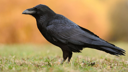

In [8]:
im = Image.open(dest)
im.to_thumb(128,128)

In [9]:
bird_types = 'crow','magpie','jackdow'
path = Path('birds')

In [10]:
if not path.exists():
    path.mkdir()
    for o in bird_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bird')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [11]:
fns = get_image_files(path)
fns

(#413) [Path('birds/jackdow/00000127.jpg'),Path('birds/jackdow/00000099.jpg'),Path('birds/jackdow/00000009.jpg'),Path('birds/jackdow/00000039.jpg'),Path('birds/jackdow/00000143.jpg'),Path('birds/jackdow/00000056.jpg'),Path('birds/jackdow/00000104.jpg'),Path('birds/jackdow/00000079.jpg'),Path('birds/jackdow/00000139.jpg'),Path('birds/jackdow/00000029.jpg')...]

In [12]:
failed = verify_images(fns)
failed

(#6) [Path('birds/crow/00000069.jpg'),Path('birds/crow/00000138.jpg'),Path('birds/magpie/00000071.jpg'),Path('birds/magpie/00000078.jpg'),Path('birds/magpie/00000073.jpg'),Path('birds/magpie/00000136.jpg')]

In [13]:
failed.map(Path.unlink);

## From Data to DataLoaders

In [14]:
birds = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [15]:
dls = birds.dataloaders(path)

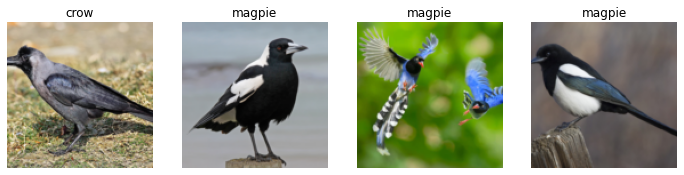

In [16]:
dls.valid.show_batch(max_n=4, nrows=1)

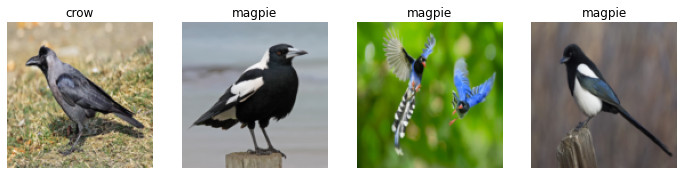

In [17]:
birds = birds.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = birds.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

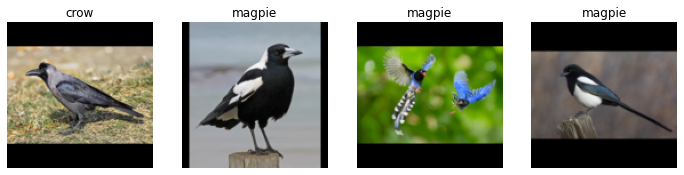

In [18]:
birds = birds.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = birds.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

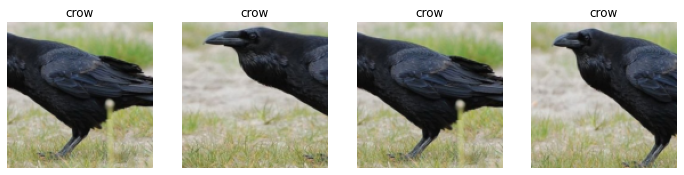

In [19]:
birds = birds.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = birds.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

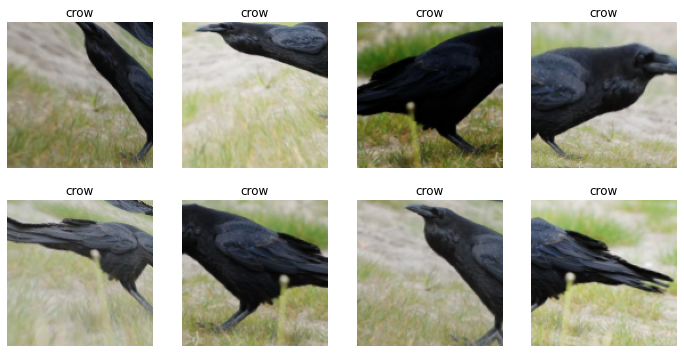

In [20]:
birds = birds.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = birds.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [21]:
birds = birds.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = birds.dataloaders(path)

In [22]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.540418,1.408988,0.320988,00:16


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.660181,0.681488,0.197531,00:16
1,0.539284,0.486490,0.135802,00:16
2,0.441671,0.408847,0.086420,00:16
3,0.376371,0.356401,0.074074,00:16


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


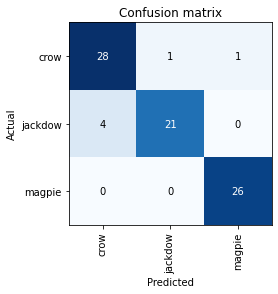

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

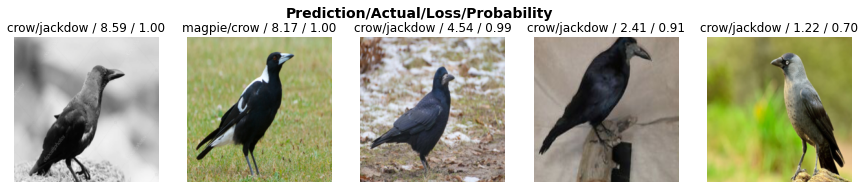

In [24]:
interp.plot_top_losses(5, nrows=1)

In [25]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [26]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [27]:
learn.export()

In [28]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [29]:
learn_inf = load_learner(path/'export.pkl')

In [30]:
learn_inf.predict('S:\images\crow.jpg')

('crow', tensor(0), tensor([9.9920e-01, 7.9263e-04, 8.7890e-06]))

In [31]:
learn_inf.dls.vocab

['crow', 'jackdow', 'magpie']

### Creating a Notebook App from the Model

In [32]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [33]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['S:\images\crow.jpg'])

In [34]:
img = PILImage.create(btn_upload.data[-1])

In [35]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [36]:
pred,pred_idx,probs = learn_inf.predict(img)

In [37]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: crow; Probability: 0.9992')

In [38]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [39]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [40]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [41]:
VBox([widgets.Label('Select your bird!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning Your Notebook into a Real App

In [42]:
#hide
#!pip install nbconvert
#!pip install voila
#!jupyter serverextension enable --sys-prefix voila 